<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_29_test_transfer_learning_with_stratifiedKFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import joblib
import glob
import random
from itertools import product
import gc
import subprocess
import shutil
import copy
import statistics as st
from scipy import stats

from imutils import rotate as rotate
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Concatenate

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, cohen_kappa_score, zero_one_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV

# from tensorflow.keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.preprocessing.image import save_img

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
#from livelossplot import PlotLossesKeras

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
# from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import PReLU, ReLU, LeakyReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D 
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from tensorflow.keras.models import Sequential

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from tensorflow.keras.applications import ResNet152V2
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import *


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, save_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=DeprecationWarning)

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# tf.keras.utils.plot_model(model)

In [3]:
!unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip                  

Archive:  gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip
   creating: Dataset/
   creating: Dataset/Validate/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/Test/
   creating: Dataset/Train/
  inflating: Dataset/Validate/.DS_Store  
  inflating: __MACOSX/Dataset/Validate/._.DS_Store  
   creating: Dataset/Validate/0/
   creating: Dataset/Validate/1/
  inflating: Dataset/Test/.DS_Store  
  inflating: __MACOSX/Dataset/Test/._.DS_Store  
   creating: Dataset/Test/0/
   creating: Dataset/Test/1/
  inflating: Dataset/Train/.DS_Store  
  inflating: __MACOSX/Dataset/Train/._.DS_Store  
   creating: Dataset/Train/0/
   creating: Dataset/Train/1/
  inflating: Dataset/Validate/0/12867_idx5_x651_y1801_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._12867_idx5_x651_y1801_class0.png  
  inflating: Dataset/Validate/0/16165_idx5_x3001_y1551_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._16165_idx5_x3001_y1551_class0.png  
  inflating

In [4]:
# delete a full folder including all its files and subfolders
!rm -rf processed_images/                    

In [5]:
!ls -ltr Dataset

total 12
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Test
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Train
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Validate


In [6]:
# ls -ltr: List the contents of the current directory in the long listing format ( -l ), 
#   sorted by modification time ( -t ) in reverse order ( -r ) of all files and directories beginning with file* .
# wc -l: count the number of lines

!ls -ltr Dataset/Train/0|wc -l
!ls -ltr Dataset/Train/1|wc -l

!ls -ltr Dataset/Test/0|wc -l
!ls -ltr Dataset/Test/1|wc -l

!ls -ltr Dataset/Validate/0|wc -l
!ls -ltr Dataset/Validate/1|wc -l

401
401
101
101
101
101


In [7]:
val_image_directory = '/content/Dataset/Validate'
train_image_directory = '/content/Dataset/Train'
test_image_directory = '/content/Dataset/Test'
directory_path = '/content/Dataset'

tgt_directory_path = '/content/processed_images'
tgt_train_1_image_path = '/content/processed_images/train/1/'
tgt_train_0_image_path = '/content/processed_images/train/0/'
tgt_val_1_image_path = '/content/processed_images/val/1/'
tgt_val_0_image_path = '/content/processed_images/val/0/'
tgt_test_1_image_path = '/content/processed_images/test/1/'
tgt_test_0_image_path = '/content/processed_images/test/0/'

tgt_path_list = [tgt_train_1_image_path, tgt_train_0_image_path,
                 tgt_val_1_image_path, tgt_val_0_image_path,
                 tgt_test_1_image_path, tgt_test_0_image_path
                ]

In [8]:
def preprocess(data_dir):
  images_path_1 = [data_dir + '/' +  dir + '/' for dir in os.listdir(data_dir) if dir != '.DS_Store'][0]
  images_path_0 = [data_dir + '/' +  dir + '/' for dir in os.listdir(data_dir) if dir != '.DS_Store'][1]

  images_list_1 = [images_path_1 + file for file in list(os.walk(images_path_1))[0][2] if file[0] != '.']
  images_list_0 = [images_path_0 + file for file in list(os.walk(images_path_0))[0][2] if file[0] != '.']

  return images_list_1, images_list_0

In [9]:
train_1_images_list, train_0_images_list = preprocess(train_image_directory)
test_1_images_list, test_0_images_list = preprocess(test_image_directory)
val_1_images_list, val_0_images_list = preprocess(val_image_directory)

In [10]:
len(train_1_images_list + train_0_images_list + test_1_images_list + test_0_images_list + val_1_images_list + val_0_images_list)

1200

In [11]:
len(train_1_images_list), len(train_0_images_list), len(test_1_images_list), len(test_0_images_list), len(val_1_images_list), len(val_0_images_list)

(400, 400, 100, 100, 100, 100)

In [12]:
test_img = load_img(train_1_images_list[0], color_mode ="grayscale")
test_img_arry = img_to_array(test_img)
print(type(test_img))
print(test_img.format)
print(test_img.mode)
print(test_img.size)
print(test_img.getbands())
print(test_img_arry.shape)
print("****")
test_img1 = load_img(train_1_images_list[0])
test_img1_arry = img_to_array(test_img1)
print(test_img1_arry.shape)
print(test_img1.getbands())

<class 'PIL.Image.Image'>
None
L
(50, 50)
('L',)
(50, 50, 1)
****
(50, 50, 3)
('R', 'G', 'B')


## Display the first 5 images for each class
: IDC Malignant (1) vs. IDC Benign (0)


In [13]:
IMG_SIZE = 50

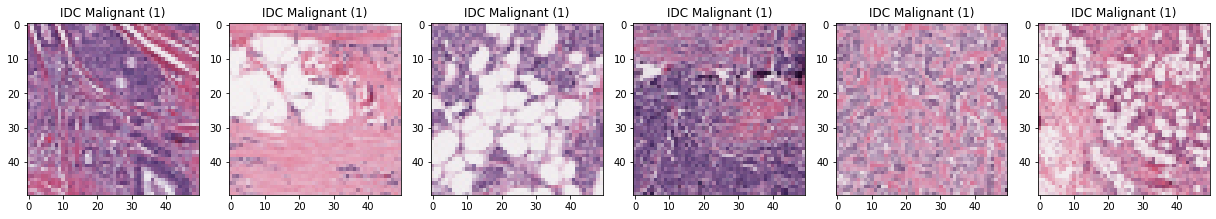

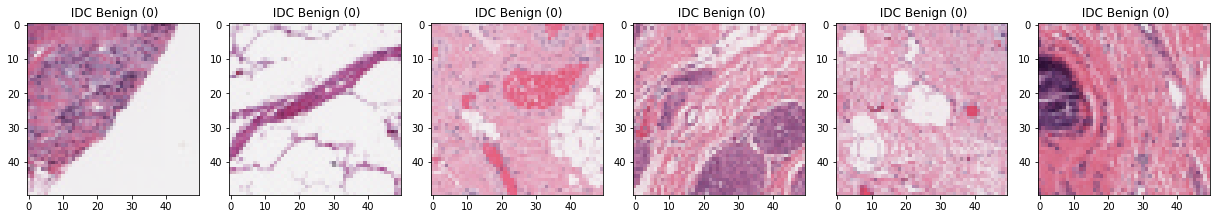

In [14]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    # ax.set_xticks([])       # remove xticks passing an empty array
    # ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_1_images_list, 'IDC Malignant (1)')
display_images(train_0_images_list, ' IDC Benign (0)')

In [15]:
# from google.colab.patches import cv2_imshow

# RESIZED_SIZE = 62

# fig = plt.figure(figsize=(22,9))

# # orig_gs = load_img(train_1_images_list[0], color_mode ="grayscale")
# # arr_orig_gs = img_to_array(orig_gs)

# orig_cs = load_img(train_1_images_list[0], color_mode ="rgb")
# arr_orig_cs = img_to_array(orig_cs)

# # =============== Original =================================
# original = io.imread(train_1_images_list[0], as_gray=False)
# ax = fig.add_subplot(2,5,1)
# ax.imshow(original)
# ax.set_title(f"Original: {IMG_SIZE} X {IMG_SIZE}", size=14)

# # # =============== Resize =================================
# resize = cv.resize(original, (RESIZED_SIZE,RESIZED_SIZE))
# # cv.resize(img, (IMG_SIZE, IMG_SIZE))
# ax = fig.add_subplot(2,5,2)
# ax.imshow(resize)
# ax.set_title(f"Resize: {RESIZED_SIZE} X {RESIZED_SIZE}", size=14)

# # =============== Horizontal Flip =========================
# h_flip = cv2.flip(original, 1)
# ax = fig.add_subplot(2,5,3)
# ax.imshow(h_flip)
# ax.set_title(f"Horizontal Flip", size=14)

# # =============== Vertical Flip ===========================
# v_flip = cv2.flip(original, 0)
# ax = fig.add_subplot(2,5,4)
# ax.imshow(v_flip)
# ax.set_title(f"Vertical Flip", size=14)

# # # =============== Rotation 45 =============================
# rot_45 = int(random.uniform(-45, 45))
# print('rot_45', rot_45)
# # # h, w = arr_orig_cs.shape[:2]
# # # print('h, w', h, w)
# # M = cv2.getRotationMatrix2D((int(IMG_SIZE/2), int(IMG_SIZE/2)), rot_45, 1)
# # rotated_img_gs = cv2.warpAffine(arr_orig_cs, M, (w, h))
# # rotated_img_gs = img_to_array(rotated_img_gs)
# # print("rot45****")
# ax = fig.add_subplot(2,5,5)
# # ax.imshow(rotated_img_gs)
# # cv2_imshow(rotated_img_gs)

# rot90_img = tf.image.rot90(original, k=1)
# ax.imshow(rot90_img)
# # ax.axis('off')
# ax.set_title('Rotate 90', size=14)


# resized = cv2.resize(test_img_arry, (224, 224), interpolation = cv2.INTER_AREA) 
# print('Resized Dimensions : ',resized.shape) 
# cv2_imshow(resized)

# # =============== Rotation 90 =============================
# angle = int(random.uniform(-90, 90))
# print('angle', angle)
# # h, w = test_img_arry.shape[:2]
# # M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
# # rotated_img_gs = cv2.warpAffine(test_img_arry, M, (w, h))
# # rotated_img_gs = img_to_array(rotated_img_gs)
# # print("rot90****")
# # cv2_imshow(rotated_img_gs)
# # print();cv2_imshow(arr_original)

# # =============== Rotation 180 ============================
# # angle = int(random.uniform(-180, 180))
# # h, w = test_img_arry.shape[:2]
# # M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
# # rotated_img_gs = cv2.warpAffine(test_img_arry, M, (w, h))
# # rotated_img_gs = img_to_array(rotated_img_gs)
# # print("rot180****")
# # cv2_imshow(rotated_img_gs)

# # # rotate ccw
# # out=cv2.transpose(test_img_arry)
# # out=cv2.flip(out,flipCode=0)
# # rotated_img_gs = img_to_array(out)
# # print("90ccwrot****")
# # cv2_imshow(out)

# # out=cv2.transpose(test_img_arry)
# # out=cv2.flip(out,flipCode=1)
# # rotated_img_gs = img_to_array(out)
# # print("90rot****")
# # cv2_imshow(out)


original****


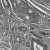

0.3_bright****


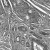

3_contrast****


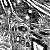

vflip****


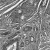

hflip****


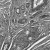

rot90****


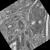

rot45****


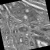

rot180****


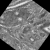

90ccwrot****


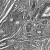

90rot****


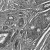

In [16]:
from google.colab.patches import cv2_imshow

test_img = load_img(train_1_images_list[0], color_mode ="grayscale")
test_img_arry = img_to_array(test_img)
print("original****")
cv2_imshow(test_img_arry)

bright_img_gs = tf.image.adjust_brightness(test_img_arry, delta=10)
bright_img_gs = img_to_array(bright_img_gs)
print("0.3_bright****")
cv2_imshow(bright_img_gs)

contrast_img_gs = tf.image.adjust_contrast(test_img_arry, contrast_factor=3)
contrast_img_gs = img_to_array(contrast_img_gs)
print("3_contrast****")
cv2_imshow(contrast_img_gs)

hflip_img_gs = cv2.flip(test_img_arry, 1)
print("vflip****")
cv2_imshow(hflip_img_gs)

vflip_img_gs = cv2.flip(test_img_arry, 0)
print("hflip****")
cv2_imshow(vflip_img_gs)

angle = int(random.uniform(-90, 90))
h, w = test_img_arry.shape[:2]
M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
rotated_img_gs = cv2.warpAffine(test_img_arry, M, (w, h))
rotated_img_gs = img_to_array(rotated_img_gs)
print("rot90****")
cv2_imshow(rotated_img_gs)

angle = int(random.uniform(-45, 45))
h, w = test_img_arry.shape[:2]
M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
rotated_img_gs = cv2.warpAffine(test_img_arry, M, (w, h))
rotated_img_gs = img_to_array(rotated_img_gs)
print("rot45****")
cv2_imshow(rotated_img_gs)

angle = int(random.uniform(-180, 180))
h, w = test_img_arry.shape[:2]
M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
rotated_img_gs = cv2.warpAffine(test_img_arry, M, (w, h))
rotated_img_gs = img_to_array(rotated_img_gs)
print("rot180****")
cv2_imshow(rotated_img_gs)

# rotate ccw
out=cv2.transpose(test_img_arry)
out=cv2.flip(out,flipCode=0)
rotated_img_gs = img_to_array(out)
print("90ccwrot****")
cv2_imshow(out)

out=cv2.transpose(test_img_arry)
out=cv2.flip(out,flipCode=1)
rotated_img_gs = img_to_array(out)
print("90rot****")
cv2_imshow(out)

Resized Dimensions :  (224, 224)


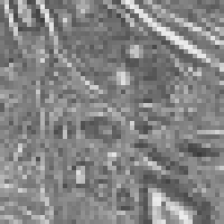

In [17]:
resized = cv2.resize(test_img_arry, (224, 224), interpolation = cv2.INTER_AREA) 
print('Resized Dimensions : ',resized.shape) 
cv2_imshow(resized)

# Filter Out Odd Images
- Exclude images that are not **50 by 50**
- Exclude images with no **.png** extension

In [18]:
odd_images = []
def extract_odd_images(file_list, IMG_SIZE = 50):
    for file_name in file_list:
        test_img = load_img(file_name, color_mode ="grayscale")
        test_img_arry = img_to_array(test_img)
        if test_img_arry.shape[0] != IMG_SIZE or test_img_arry.shape[1] != IMG_SIZE:
            odd_images.append(file_name)

In [19]:
extract_odd_images(train_1_images_list + train_0_images_list + test_1_images_list + test_0_images_list + val_1_images_list + val_0_images_list)

In [20]:
odd_images

['/content/Dataset/Train/0/13106_idx5_x1_y2951_class0.png',
 '/content/Dataset/Train/0/9347_idx5_x2101_y801_class0.png',
 '/content/Dataset/Train/0/12954_idx5_x1651_y2951_class0.png',
 '/content/Dataset/Test/0/13404_idx5_x1101_y2901_class0.png',
 '/content/Dataset/Validate/0/13694_idx5_x1551_y2801_class0.png',
 '/content/Dataset/Validate/0/9320_idx5_x801_y2951_class0.png',
 '/content/Dataset/Validate/0/12931_idx5_x1901_y2151_class0.png']

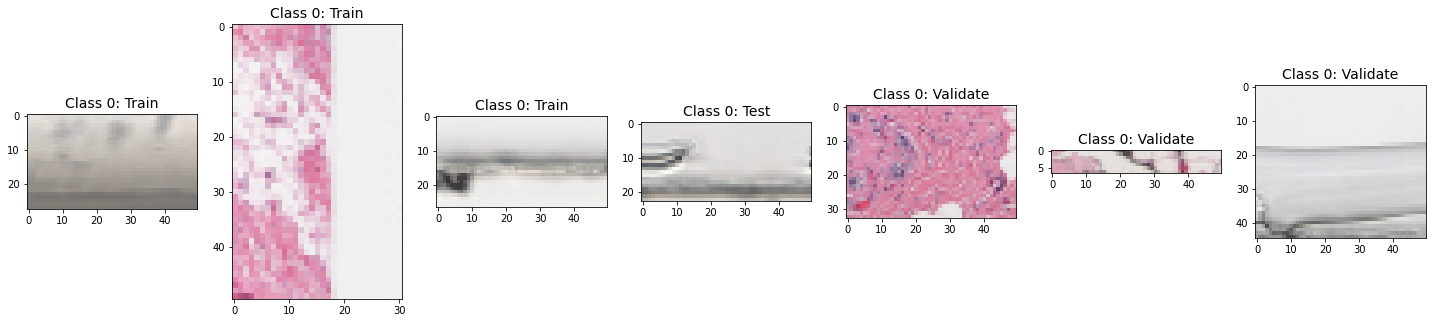

In [21]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass[idx])
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass[idx].split('/')[3]
    img = io.imread(subclass[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print();display_images(odd_images)

In [22]:
train_0_images_list[:5]

['/content/Dataset/Train/0/9322_idx5_x2901_y1951_class0.png',
 '/content/Dataset/Train/0/10254_idx5_x651_y1451_class0.png',
 '/content/Dataset/Train/0/13459_idx5_x401_y851_class0.png',
 '/content/Dataset/Train/0/12817_idx5_x2401_y201_class0.png',
 '/content/Dataset/Train/0/14191_idx5_x1701_y551_class0.png']

In [23]:
train_1_images_list[0].split("/")[-1], train_1_images_list[0][:train_1_images_list[0].rfind("/") + 1]

('9346_idx5_x1701_y1901_class1.png', '/content/Dataset/Train/1/')

In [24]:
# delete a full folder including all its files and subfolders
!rm -rf processed_images/

# Create a New Directory Path to Store Processed Images

In [25]:
root_dir = 'processed_images'

os.makedirs(f'{root_dir}', exist_ok = True)
for dir in ['train', 'val', 'test']:
    for sub_dir in ['1', '0']:
        os.makedirs(f'{root_dir}/{dir}/{sub_dir}', exist_ok=True)

# Image Augmentation on Training Dataset
- Convert color to gray scale
- Flip: Horizontal and Vertical
- Rotate 90 degree

In [26]:
# def create_gs_files(file_list, dest_dir, ind):
def create_gs_files(file_list, dest_dir, ind, brightness_delta=0.3, contrast_factor=3):
  # print(file_list, dest_dir, ind)
  lst_train_1_gs, lst_train_0_gs = [], []
  lst_val_1_gs, lst_val_0_gs = [], []
  lst_test_1_gs, lst_test_0_gs = [], []

  file_extension = '.png'
  for image_file in file_list:
      #print(image_file)
      if image_file[0] == '.' or image_file in odd_images:                                     # if image_file = .DS_Store or an odd image then ignore
          continue
      img_gs = load_img(image_file, color_mode = "grayscale")                                     # convert images from colorscale to grayscale
      img_array_gs = img_to_array(img_gs)                                                         # convert grayscale images to array
      #print("a")
      #img_array_gs = cv2.resize(img_array_gs, (224, 224), interpolation = cv2.INTER_AREA)
      
      file_name = image_file.split("/")[-1]                                                       # extract only filenames from the full file path
      save_img(dest_dir + file_name.split(".")[0] + '_gs' + file_extension, img_array_gs)
      if ind == 1:
          # insert raw training images in gray scale
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)

          # adjust brightness
          bright_img_gs = tf.image.adjust_brightness(img_array_gs, delta=brightness_delta)
          img_array_bright_gs = img_to_array(bright_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension, img_array_bright_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension)
          
          # adjust contrast
          contrast_img_gs = tf.image.adjust_contrast(img_array_gs, contrast_factor=contrast_factor)
          img_array_contrast_gs = img_to_array(contrast_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension, img_array_contrast_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension)

          # horizontal flip
          hflip_img_gs = cv2.flip(img_array_gs, 1)
          img_array_hflip_gs = img_to_array(hflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension, img_array_hflip_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension)

          # vertical flip
          vflip_img_gs = cv2.flip(img_array_gs, 0)
          img_array_vflip_gs = img_to_array(vflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension, img_array_vflip_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension)

          # rotate 90 degree
          angle = int(random.uniform(-90, 90))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension)
          '''
          angle = int(random.uniform(-279, 270))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension)
          
          img_90rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_90_CLOCKWISE)
          img_array_90rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_90rot_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          
          img_180rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_180_CLOCKWISE)
          img_array_180rot_gs = img_to_array(img_180rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension, img_array_180rot_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension)

          img_270rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_270_CLOCKWISE)
          img_array_270rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_270rot_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          '''
          #  histogram equalized image
          img_gs = cv2.imread(image_file, 0)
          img_array_enhanced_gs = cv2.equalizeHist(img_gs)
          img_array_enhanced_gs = img_to_array(img_array_enhanced_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_enhance_gs' + file_extension, img_array_enhanced_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_enhanced_gs' + file_extension)

          # transpose and rotate 90 degrees counter clockwise (flip around x-axis)
          img_ccw90rot_gs = cv2.transpose(img_array_gs)
          img_ccw90rot_gs = cv2.flip(img_ccw90rot_gs, flipCode = 0)
          rotatedccw90_img_gs = img_to_array(img_ccw90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension, rotatedccw90_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension)
          #print("e")

          # transpose and rotate 90 degrees (flip around y-axis)
          img_90rot_gs = cv2.transpose(img_array_gs)
          img_90rot_gs = cv2.flip(img_90rot_gs, flipCode = 1)
          rotated90_img_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, rotated90_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          #print("f")

      elif ind == 2:
          # insert raw training images in gray scale
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)

          # adjust brightness
          bright_img_gs = tf.image.adjust_brightness(img_array_gs, delta=brightness_delta)
          img_array_bright_gs = img_to_array(bright_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension, img_array_bright_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension)
          
          # adjust contrast
          contrast_img_gs = tf.image.adjust_contrast(img_array_gs, contrast_factor=contrast_factor)
          img_array_contrast_gs = img_to_array(contrast_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension, img_array_contrast_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension)

          # horizontal flip
          hflip_img_gs = cv2.flip(img_array_gs, 1)
          img_array_hflip_gs = img_to_array(hflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension, img_array_hflip_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension)

          # vertical flip
          vflip_img_gs = cv2.flip(img_array_gs, 0)
          img_array_vflip_gs = img_to_array(vflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension, img_array_vflip_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension)

          # rotate 90 degree
          angle = int(random.uniform(-90, 90))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension)
          '''
          angle = int(random.uniform(-279, 270))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension)
          
          img_90rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_90_CLOCKWISE)
          img_array_90rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_90rot_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          
          img_180rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_180_CLOCKWISE)
          img_array_180rot_gs = img_to_array(img_180rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension, img_array_180rot_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension)

          img_270rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_270_CLOCKWISE)
          img_array_270rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_270rot_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          '''
          #  histogram equalized image
          img_gs = cv2.imread(image_file, 0)
          img_array_enhanced_gs = cv2.equalizeHist(img_gs)
          img_array_enhanced_gs = img_to_array(img_array_enhanced_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_enhance_gs' + file_extension, img_array_enhanced_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_enhanced_gs' + file_extension)

          # transpose and rotate 90 degrees counter clockwise (flip around x-axis)
          img_ccw90rot_gs = cv2.transpose(img_array_gs)
          img_ccw90rot_gs = cv2.flip(img_ccw90rot_gs, flipCode = 0)
          rotatedccw90_img_gs = img_to_array(img_ccw90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension, rotatedccw90_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension)

          # transpose and rotate 90 degrees (flip around y-axis)
          img_90rot_gs = cv2.transpose(img_array_gs)
          img_90rot_gs = cv2.flip(img_90rot_gs, flipCode = 1)
          rotated90_img_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, rotated90_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)

      elif ind == 3:
          lst_val_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif ind == 4:
          lst_val_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif ind == 5:
          lst_test_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif ind == 6:
          lst_test_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
              

In [27]:
# len(os.listdir('/content/Dataset/Validate/0'))

# Store Processed Images to New Directory
- Convert color to gray scale
- Append augmented images

In [28]:
create_gs_files(train_1_images_list, tgt_train_1_image_path, 1, 0.3, 3)
print(len(os.listdir('/content/Dataset/Train/1')))
print(len(os.listdir(tgt_train_1_image_path)))
create_gs_files(train_0_images_list, tgt_train_0_image_path, 2, 0.3, 3)
print(len(os.listdir('/content/Dataset/Train/0')))
print(len(os.listdir(tgt_train_0_image_path)))

create_gs_files(val_1_images_list, tgt_val_1_image_path, 3, 0.3, 3)
print(len(os.listdir('/content/Dataset/Validate/1')))
print(len(os.listdir(tgt_val_1_image_path)))
create_gs_files(val_0_images_list, tgt_val_0_image_path, 4, 0.3, 3)
print(len(os.listdir('/content/Dataset/Validate/0')))
print(len(os.listdir(tgt_val_0_image_path)))

create_gs_files(test_1_images_list, tgt_test_1_image_path, 5, 0.3, 3)
print(len(os.listdir('/content/Dataset/Test/1')))
print(len(os.listdir(tgt_test_1_image_path)))
create_gs_files(test_0_images_list, tgt_test_0_image_path, 6, 0.3, 3)
print(len(os.listdir('/content/Dataset/Test/0')))
print(len(os.listdir(tgt_test_0_image_path)))

401
3600
401
3573
101
100
101
97
101
100
101
99


In [29]:
!ls -ltr /content/Dataset/Train/1/*.png|wc -l
!ls -ltr /content/Dataset/Train/0/*.png|wc -l

400
400


# Check the Number of Processed Images in Each Class of Training Dataset

In [30]:
!ls -ltra /content/processed_images/train/1/*.png|wc -l
!ls -ltra /content/processed_images/train/0/*.png|wc -l

3600
3573


In [31]:
# def custom_augmentation(np_tensor):
 
#     def random_contrast(np_tensor):
#         return tf.image.random_contrast(np_tensor, 0.5, 2)
 
#     def random_hue(np_tensor):
#         return tf.image.random_hue(np_tensor, 0.5)
 
#     def random_saturation(np_tensor):
#         return tf.image.random_saturation(np_tensor, 0.2, 3)
 
#     def gaussian_noise(np_tensor):
#         mean = 0
#         # variance: randomly between 1 to 25
#         var = np.random.randint(1, 26)
#         # sigma is square root of the variance value
#         noise = np.random.normal(mean,var**0.5,np_tensor.shape)
#         return np.clip(np_tensor + noise, 0, 255).astype('int')

#     augmnted_tensor = random_contrast(np_tensor)
#     augmnted_tensor = random_hue(augmnted_tensor)
#     augmnted_tensor = random_saturation(augmnted_tensor)
#     augmented_tensor = gaussian_noise(augmnted_tensor)
  
#     return np.array(augmnted_tensor)

# # Train data generator
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     #featurewise_center            = True, 
#     #featurewise_std_normalization = True,
#     rescale                       = 1.0/255
# )

# # Validation data generator
# val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     #featurewise_center            = True, 
#     #featurewise_std_normalization = True
#     rescale = 1.0/255
#     )

# # Test data generator
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     #featurewise_center            = True, 
#     #featurewise_std_normalization = True
#     rescale = 1.0/255
#     )

# Define Transfer Learning Models

In [32]:
def build_transfer_learning_model(chosen_model):
    """
    This function utilizes transfer learning of a given model.
    """
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    tf.keras.backend.clear_session()

    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    if chosen_model == 'VGG19':
        model_tl = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'DenseNet201':
        model_tl = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'ResNet50':
        model_tl = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'ResNet152V2':
        model_tl = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = input_shape)       
    elif chosen_model == 'VGG16':
        model_tl = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'EfficientNetB7':
        model_tl = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'MobileNetV2':
        model_tl = MobileNetV2(weights='imagenet',include_top = False, input_shape=input_shape)
    elif chosen_model == 'Xception':
        model_tl = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'InceptionV3':
        model_tl = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
    return model_tl

# Define plot_model_accuracy_and_loss function

In [33]:
def plot_model_accuracy_and_loss(history, chosen_model):
   """
   This method plots model training and validation accuracies.
   """
   tf.keras.backend.clear_session()

   hist = history.history
   x_arr = np.arange(len(hist['loss'])) + 1
        
   fig = plt.figure(figsize=(12, 4))
   ax = fig.add_subplot(1, 2, 1)
   ax.plot(x_arr, hist['loss'], '-o', label = 'Train loss')
   ax.plot(x_arr, hist['val_loss'], '--<', label = 'Validation loss')
   ax.legend(fontsize=15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Loss', size = 15)

   ax = fig.add_subplot(1, 2, 2)
   ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train acc.')
   ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Validation acc.')
   ax.legend(fontsize = 15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Accuracy', size = 15)
   ax.set_ylim(0,1)
   plt.title(f"{chosen_model}")
   plt.show(block = False)

# Define Image Data Generator 
: 1200 given raw images + augmented images

In [34]:
batch_size = 64
random_state = 1234

def data_generator(): 
  processed_images_train_path = '/content/processed_images/train'           # contains augmented images with original images (4782 = IDC(1): 2400 + IDC(1): 2382)
  processed_images_validation_path = '/content/processed_images/val'
  processed_images_test_path = '/content/processed_images/test'

  # train_datagen = ImageDataGenerator(rescale = 1./255,
  #                                  horizontal_flip = True,
  #                                  vertical_flip = True,
  #                                  rotation_range = 180,
  #                                  zoom_range = 0.4, 
  #                                  width_shift_range = 0.3,
  #                                  height_shift_range = 0.3,
  #                                  shear_range = 0.3
  #                                  #,preprocessing_function = custom_augmentation 
  #                                 )

  # # Validation data generator
  # val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  #     rescale = 1.0/255
  #     )

  # # Test data generator
  # test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  #     rescale = 1.0/255
  #     )


  datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)

  train_data_generator = datagen.flow_from_directory(processed_images_train_path,
                                                                      target_size = (IMG_SIZE, IMG_SIZE),
                                                                      class_mode = 'categorical',
                                                                      batch_size = batch_size,
                                                                      color_mode = 'rgb',
                                                                      shuffle = True,
                                                                      seed = random_state
                                                                      )
  val_data_generator = datagen.flow_from_directory(processed_images_validation_path,
                                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                                  class_mode = 'categorical',
                                                                  batch_size = batch_size,
                                                                  color_mode = 'rgb',
                                                                  shuffle = True,
                                                                  seed = random_state
                                                                  )
  test_data_generator = datagen.flow_from_directory(processed_images_test_path,
                                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                                    batch_size = batch_size,
                                                                    class_mode = 'categorical',
                                                                    color_mode = 'rgb',
                                                                    shuffle = False,
                                                                    seed = random_state
                                                                    )
  return train_data_generator, val_data_generator, test_data_generator

train_data_generator, val_data_generator, test_data_generator = data_generator()

Found 7173 images belonging to 2 classes.
Found 197 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [35]:
# transfer_learning_model_list = ['VGG16', 
#                                 'VGG19', 
#                                 'DenseNet201', 
#                                 'InceptionV3', 
#                                 'ResNet50', 
#                                 'EfficientNetB7', 
#                                 'MobileNetV2', 
#                                 'Xception'
#                                ]

## Define Model
- Build CNN with Transfer Learning and model.compile
- model.fit
- model.evaluate and model.predict

In [36]:
def cnn_with_tl(chosen_model='VGG16', 
                lr=0.001, 
                optimizer='adam', 
                activation='relu', 
                dropout_rate_1=0.2, 
                dropout_rate_2=0.2, 
                dropout_rate_3=0.2, 
                filter_1=512,
                filter_2=512,
                filter_3=256,
                last_dense=True):
  
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)

  model_tl = build_transfer_learning_model(chosen_model = chosen_model)
  model_tl.trainable = False            # freeze extraction layers

  # 1st model: add custom top layers
  m_tl = model_tl.output
  m_tl = GlobalAveragePooling2D()(m_tl)
  m_tl = BatchNormalization()(m_tl)
  m_tl = Dropout(dropout_rate_1)(m_tl)
  # if dense_1:
  m_tl = Dense(filter_1,activation=activation)(m_tl)
  m_tl = BatchNormalization()(m_tl)
  m_tl = Dropout(dropout_rate_2)(m_tl)                                        # ADDITIONAL DROPOUT
  m_tl = Flatten()(m_tl)                                           # ADD FLATTEN LAYER
  m_tl = Dense(filter_2,activation=activation)(m_tl)
  m_tl = BatchNormalization()(m_tl)
  m_tl = Dropout(dropout_rate_3)(m_tl)
  if last_dense:
    m_tl = Dense(filter_3,activation=activation)(m_tl)
    m_tl = BatchNormalization()(m_tl)

  # output layer
  m_tl = Dense(2, activation='softmax')(m_tl)               # UPDATED from 'sigmoid' to 'softmax

  model = Model(inputs=model_tl.input, outputs=m_tl)

  # ==================== model.compile ====================================
  def selected_optimizer(optimizer):
    if optimizer.lower() == 'sgd':
        return SGD(learning_rate=lr)           # SGD(learning_rate=learning_rate, momentum=0.95, decay=1, nesterov=True)
    elif optimizer.lower() == 'adam':
        return Adam(learning_rate=lr)          # Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
    elif optimizer.lower() == 'rmsprop':
        return RMSprop(learning_rate=lr) 

  model.compile(loss=CategoricalCrossentropy(),            
              optimizer=selected_optimizer(optimizer),            
              metrics=['accuracy'])
  return model

In [37]:
def model_fit(model, batch_size=64, epochs=20, chosen_model='VGG16'):
  from IPython.display import Image

  tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
  Image(filename='convnet.png') 

  callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
              ModelCheckpoint('model.hdf5', save_best_only=True)]

  history = model.fit(train_data_generator,
                      epochs = epochs,
                      batch_size = batch_size,                       # ADDIITION
                      shuffle=True,                                  # ADDIITION
                      steps_per_epoch = len(train_data_generator),
                      validation_data = val_data_generator,
                      validation_steps = len(val_data_generator),
                      callbacks=callbacks,                           # ADDIITION
                      verbose = 1)

  # ============= Model save ================================================
  print("Saving model...")
  tf.keras.backend.clear_session()
  # gc.collect()                                                      # UPDATED
  model.save('breast_cancer_detection_' + chosen_model + '.h5')

  # ============= Plot loss and accuracy of model: train vs val ==========
  print(f"{chosen_model}")
  plot_model_accuracy_and_loss(history = history, chosen_model = chosen_model)
  return model, history

In [38]:
def model_evaluate_and_model_predict(model, history, chosen_model='VGG16', lr=0.001,optimizer='adam', activation='relu'):
  # =========== model.evaluate ===============================================
  # test_loss, test_accuracy, precision1, recall1, auc1 = model.evaluate(test_data_generator, verbose = 0)
  test_loss, test_accuracy = model.evaluate(test_data_generator, verbose = 0)
  training_accuracy = history.history['accuracy'][-1]
  val_accuracy = history.history['val_accuracy'][-1]
  count_trainable_params = count_params(model.trainable_weights)

  # =========== model.predict: y_true vs. y_pred =============================
  classes = ['IDC(0)','IDC(1)']

  y_true = test_data_generator.classes
  y_pred = model.predict(test_data_generator, steps = (test_data_generator.n // batch_size + 1), verbose = 0)
  y_pred_argmax = np.argmax(y_pred, axis=1) 

  # ========== Precision, recall, f1score ====================================
  precision, recall, f1score, support = score(y_true, y_pred_argmax, average='macro')

  # ========== Cohen_kappa score, zero_one loss ==============================
  cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
  zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

  # ========== Confusion matrix ==============================================
  conf_max = confusion_matrix(y_true, y_pred_argmax)             # conf.max should use 0s and 1s for y_pred
  perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
  df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

  print();plt.figure(figsize=(6,5))
  sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
  plt.xlabel('Predicted Label', fontsize=14)
  plt.ylabel('True Label', fontsize=14)
  plt.title('Confusion Matrix (%)', fontsize=15)

  # ========== Area under the ROC curve ======================================
  roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
  fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
  area_under_curve = round(metrics.auc(fpr, tpr), 2) 

  print();plt.figure(figsize=(6,5))
  plt.plot([0, 1], [0, 1], 'r--')  
  plt.plot(fpr, tpr, label='ROC-AUC: {:.2f}'.format(area_under_curve))  
  plt.xlabel('False positive rate', fontsize=14)
  plt.ylabel('True positive rate', fontsize=14)
  plt.title('ROC Area Under Curve', fontsize=18)
  plt.legend(loc='best')
  plt.show()

  # ========== Performace metrics summary ===================================
  perf_metrics = pd.DataFrame({'TL Model':chosen_model, 
                              # 'Learning Rate': lr,
                              # 'Optimizer': optimizer.upper(), 
                              # 'Activation': activation.title(),
                              # 'Dropout': activation.title(),
                              # 'Test_Loss':round(test_loss,2), 
                              'Test_Acc':round(test_accuracy, 2), 
                              'Train_Acc':round(training_accuracy, 2), 
                              'Val_Acc':round(val_accuracy, 2), 
                              'Num_Trainable_Params':  f'{count_trainable_params:,}',
                              'Precision':round(precision, 2), 
                              'Recall':round(recall, 2), 
                              'F1score': round(f1score, 2),
                              'ROC-AUC':round(area_under_curve, 2), 
                              'Cohen Kappa': cohen_kappa,
                              'Zero-One Loss': zo_loss}, index=[0])

  return perf_metrics

# Run Experiments

In [39]:
def experimenting_cnn_with_vgg16(chosen_model='VGG16',
                                lr=0.01, 
                                optimizer='adam', 
                                activation='relu', 
                                dropout_rate_1=0.2, 
                                dropout_rate_2=0.2, 
                                dropout_rate_3=0.2,
                                filter_1=512,
                                filter_2=512,
                                filter_3=256,
                                last_dense=True,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=0.3,
                                contrast_factor=3):
  
  create_gs_files(train_1_images_list, tgt_train_1_image_path, 1, brightness_delta, contrast_factor)
  create_gs_files(train_0_images_list, tgt_train_0_image_path, 2, brightness_delta, contrast_factor)
  create_gs_files(val_1_images_list, tgt_val_1_image_path, 3, brightness_delta, contrast_factor)
  create_gs_files(val_0_images_list, tgt_val_0_image_path, 4, brightness_delta, contrast_factor)
  create_gs_files(test_1_images_list, tgt_test_1_image_path, 5, brightness_delta, contrast_factor)
  create_gs_files(test_0_images_list, tgt_test_0_image_path, 6, brightness_delta, contrast_factor)
  
  start_time = time.time()
  model = cnn_with_tl(chosen_model=chosen_model, 
                  lr=lr, 
                  optimizer=optimizer, 
                  activation=activation, 
                  dropout_rate_1=dropout_rate_1, 
                  dropout_rate_2=dropout_rate_2, 
                  dropout_rate_3=dropout_rate_3,
                  filter_1=filter_1,
                  filter_2=filter_2,
                  filter_3=filter_3,
                  last_dense=last_dense)
  model, history = model_fit(model, batch_size=batch_size, epochs=epochs, chosen_model=chosen_model)
  perf_metrics = model_evaluate_and_model_predict(model, history, chosen_model=chosen_model)
  # perf_metrics['Brightness Delta'] = brightness_delta
  # perf_metrics['Contrast Factor'] = contrast_factor

  print();print('Execution time %s minutes: ' % round(int(time.time() - start_time)/60, 2),'\n');print('===============================================\n')
  return perf_metrics

In [40]:
# learning_rate = [0.001,0.01, 0.01,0.01,0.01,0.01,0.01]
# optimizer = ['SGD','SGD','Adam','Adam','Adam','Adam','Adam']
# activation = ['leaky_relu','leaky_relu','tanh','tanh','relu','relu','leaky_relu']
# dropout_rate_1 = [0.5, 0.5,0.2, 0.3, 0.3, 0.5, 0.5]
# dropout_rate_2 = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4] 
# dropout_rate_3 = [ 0.2, 0.2, 0.2, 0.2, 0.2, 0, 0]
# filter_1 = [512,512,512,512,512,1024,1024]
# filter_2 = [512,512,512,512,512,128,128]
# filter_3 = [256,256,256,256,256,0,0]
# last_dense = [True,True,True,True,True,False,False]
# brightness_delta = [0.3,0.3,0.1,0.1,0.3,0.3,0.3]
# contrast_factor = [3,3,3,3,3,3,3]      

learning_rate = [0.01,0.01,0.01, 0.01]
optimizer = ['Adam','Adam','Adam','SGD']
activation = ['tanh','tanh','tanh','leaky_relu']
dropout_rate_1 = [0.2, 0.3, 0.4,0.4]
dropout_rate_2 = [0.2, 0.2, 0.2, 0.2] 
dropout_rate_3 = [0.2, 0.2, 0.2, 0.2]
filter_1 = [512,512,512,512]
filter_2 = [512,512,512,512]
filter_3 = [256,256,256,256]
last_dense = [True,True,True,True]
brightness_delta = [0.1,0.1,0.3,0.3]
contrast_factor = [3,3,3,3]    

# learning_rate = [0.01,0.01]
# optimizer = ['Adam','Adam']
# activation = ['tanh','tanh']
# dropout_rate_1 = [0.2, 0.3]
# dropout_rate_2 = [0.2, 0.2] 
# dropout_rate_3 = [0.2, 0.2]
# filter_1 = [512,512]
# filter_2 = [512,512]
# filter_3 = [256,256]
# last_dense = [True,True]
# brightness_delta = [0.1,0.1]
# contrast_factor = [3,3]         
                                
print(len(learning_rate),
      len(optimizer),
      len(activation),
      len(dropout_rate_1),
      len(filter_1),
      len(last_dense),
      len(brightness_delta),
      len(contrast_factor))

param_tuples = list(zip(learning_rate,optimizer,activation,dropout_rate_1,dropout_rate_2,dropout_rate_3,filter_1,filter_2,filter_3,last_dense,brightness_delta,contrast_factor))
df_experiments = pd.DataFrame(param_tuples, columns=['learning_rate','optimizer','activation','dropout_rate_1','dropout_rate_2','dropout_rate_3','filter_1','filter_2','filter_3','last_dense','brightness_delta','contrast_factor'])
df_experiments

4 4 4 4 4 4 4 4


,learning_rate,optimizer,activation,dropout_rate_1,dropout_rate_2,dropout_rate_3,filter_1,filter_2,filter_3,last_dense,brightness_delta,contrast_factor
0,0.01,Adam,tanh,0.2,0.2,0.2,512,512,256,True,0.1,3
1,0.01,Adam,tanh,0.3,0.2,0.2,512,512,256,True,0.1,3
2,0.01,Adam,tanh,0.4,0.2,0.2,512,512,256,True,0.3,3
3,0.01,SGD,leaky_relu,0.4,0.2,0.2,512,512,256,True,0.3,3


In [ ]:
# tl_models = ['VGG16', 'VGG19', 'DenseNet201', 'ResNet50', 'ResNet152V2', 'MobileNetV2']               #  'EfficientNetB7',    # input_shape should be one of [96, 128, 160, 192, 224]
# tl_models = ['VGG16', 'ResNet152V2'] 
tl_models = ['VGG16']

def run_experiments():
  metrics_table = pd.DataFrame()
  # for tl in tl_models:     
  for i in range(len(learning_rate)):
    perf_metrics = experimenting_cnn_with_vgg16(chosen_model='VGG16',
                                                lr=learning_rate[i], 
                                                optimizer=optimizer[i], 
                                                activation=activation[i], 
                                                dropout_rate_1=dropout_rate_1[i],  
                                                dropout_rate_2=dropout_rate_2[i],  
                                                dropout_rate_3=dropout_rate_3[i], 
                                                filter_1=filter_1[i], 
                                                filter_2=filter_2[i], 
                                                filter_3=filter_3[i], 
                                                last_dense=last_dense[i], 
                                                batch_size=64,
                                                epochs=20,
                                                brightness_delta=brightness_delta[i], 
                                                contrast_factor=contrast_factor[i])   # chosen_model=tl,
    perf_metrics['lr'] = learning_rate[i]
    perf_metrics['optimizer'] = optimizer[i].upper()
    perf_metrics['activation'] = activation[i].title()
    # perf_metrics['dr_1'] = dropout_rate_1[i]
    # perf_metrics['dr_2'] = dropout_rate_2[i]
    # perf_metrics['dr_3'] = dropout_rate_3[i]
    # perf_metrics['ft_1'] = filter_1[i]
    # perf_metrics['ft_2'] = filter_2[i]
    # perf_metrics['ft_3'] = filter_3[i]
    # perf_metrics['last_dense'] = last_dense[i]
    perf_metrics['brightness'] = brightness_delta[i]
    perf_metrics['contrast'] = contrast_factor[i]
    metrics_table = metrics_table.append(perf_metrics, ignore_index=True)
  return metrics_table

perf_metrics = run_experiments()
perf_metrics

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
113/113 [==============================] - 209s 2s/step - loss: 0.8129 - accuracy: 0.6695 - val_loss: 0.6570 - val_accuracy: 0.6447
Epoch 2/20
 34/113 [========>.....................] - ETA: 2:07 - loss: 0.5689 - accuracy: 0.7160

In [ ]:
# learning_rate = [0.001,0.001,0.01]
# optimizer =['Adam','Adam','Adam']

# def test():
#   df = pd.DataFrame().T

#   for i in range(len(optimizer)):
#     df1 = pd.DataFrame([20,30,40], columns=['num']).T
#     # df['lr'] = learning_rate[i]
#     # df['opt'] = optimizer[i]
#     df = df.append(df1, ignore_index=True)
#   return df
# test()